# Cars 2015 - Twitter Data Analysis


<br>
Twitter tweets are an attractive data source to analyze as Twitter users tweet about many different topics in which they not only impart knowledge to others but also express their feelings and opinions. Analyzing this data can result in valuable insights and can be useful to detect trends and drive business decisions. Notebooks are a powerful platform for data scientists to analyze Twitter data.
<br>

<br>
This notebook shows how to analyze Twitter data to glean insights from the automotive industry. As the automotive industry is one of the largest industries in the world and still very much a growth industry, analyzing tweets about cars can assist manufacturers to pay closer attention to market dynamics and position their companies to take advantage of demographic  changes and shifts in consumer expectations.
<br>

 The sample is structured into different sections. In the first sections, you will perform a general analysis on data set then you will go deeper in the analysis to gain meaningful insights about manufacturers.


### Learning goals:
1. Determine the countries with the highest number of tweets (based on the user profile information).

2. Analyze tweet sentiments

3. Draw insights from tweets about major car manufacturers world wide by combining Twitter timeline analysis with sentiment, determining gender distribution and location distribution.

4. Draw insights about attractive car features across car makers.


### Preparing the data set and data flow
#### Data source
The first step in the analysis process is to harvest the twitter data. In this sample, we use the DashDB connector to the IBM Insights for Twitter service to seamlessly specify a filter query and load the results into DashDB. A query is used to filter the tweets and return only those that were posted about 6 leading car manufacturers in 2015 such as Volkswagen, Toyota, Daimler, BMW and GM.

##### Notes: 
1) The query captures alternative spellings of car manufactures. For example, Volkswagen and VW.

2) The query does not filter out alternative meanings of a car model abbreviation. For example, GM can mean General Motors and Good Morning.

3) The query is '(posted:2015-01-01,2015-12-31) (volkswagen OR vw OR toyota OR daimler OR mercedes OR bmw OR gm OR "general motors" OR tesla)'.

4) The query above will produce around 5 Millions tweets which results in delays loading the data. User can limit the size of the data set by adding more filter constraints. e.g: **'posted:2015-01-01,2015-12-31 friends_count:5000 followers_count:5000 listed_count:5000 is:verified (sentiment:positive OR sentiment:negative OR sentiment:ambivalent) (volkswagen OR vw OR toyota OR daimler OR mercedes OR bmw OR gm OR "general motors" OR tesla)'**

### Analyzing tweets

In this notebook sample, you will use SparkContext which enables you to run tasks on the Spark cluster. Using Spark in notebooks enables you to analyze large amounts of data very efficiently. The sample begins with basic analysis steps which slowly progress into deeper analytic work. 
In this Notebook, we will analyze the loaded data to extract interesting insights and plots from it. This analysis is performed using SparkContext which enables us to run tasks on spark cluster. Using spark and notebooks is a very strong combination. It enables you to analyze big amount of data very efficiently. We will start with some basic analysis then go deeper gradually.


##### Notebook structure
1. Importing libraries
2. Defining global variables and helper functions
3. Acquiring the data
4. Transforming the data
5. Determining the distribution of tweets across geographies
6. Analyzing tweet sentiments
7. Analyzing Twitter timelines
8. Drawing insights from tweets about car manufacturers
9. Drawing insights about car features
10. Summary

# 1. Importing libraries
Run the following cell to install the needed libraries you will work with in the sample.

In [1]:
!pip install nltk --user

In [2]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /gpfs/fs01/user/s85f-
[nltk_data]     231ef37d0b5f3c-49274b5c09ed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from pyspark.sql import SQLContext
from pyspark.sql import functions as F

import time
from datetime import date
from dateutil import parser

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import numpy as np

from IPython.core.display import Javascript

from __future__ import division

%matplotlib inline

sqlContext = SQLContext(sc)

# 2. Defining global variables and helper functions

In this sample, you will use the variables:
- car_marker_list which contains all car manifacturers. Each element in the array is a list with all spelling variants of each manufacturer.
- list car_makers_name_list which contains the most common spelling variant of each car manufacturer.

In [4]:
car_makers_list = [['bmw'], ['daimler', 'mercedes'], ['gm', 'general motors'], ['tesla'], ['toyota'], ['vw', 'volkswagen']]

car_makers_name_list = []
for car_maker in car_makers_list:
    car_makers_name_list.append(car_maker[0].upper())

#plotting variables
ind = np.arange(len(car_makers_list)) #index list for plotting
width = 0.8       # the width of the bars in the bar plots

num_car_makers = len(car_makers_list)

##car features #support English, Deutsch, french, Spanish
electric_vehicle_terms = ['electric car', 'electric vehicle', 'electric motor', 'hybrid vehicle', 'Hybrid car', 'elektroauto', 'elektrofahrzeug', 
                          'hybridautos', 'voiture hyprid', 'coche híbrido', 'Auto Hibrido', 'vehículo híbrido', 'elektrovehikel', 'voiture électrique', 'coche eléctrico']
auto_driver_terms = ['auto drive', 'autodrive', 'autonomous', 'driverless', 'self driving', 'robotic', 'autonomes', 'selbstfahrendes', 'autonome', 'autónomo']

SCHEMA="DASH7504."
PREFIX="PYCON_"

The sample uses the helper function called GeoChart to plot the world map in a DOM element (an iframe).


The helper function addMissingDates checks for any missing dates in DataFrames with time series data.
* baseDataframe: this DataFrame contains all dates. It must have the column names [POSTING_TIME, NUM_TWEETS]
* checkedDataframe: this DataFrame contains the dates that need to be checked. It must have the column names [POSTING_TIME, NUM_TWEETS]

In [5]:
def GeoChart(data_string, element):
    return Javascript("""
        //container.show();
        function draw() {{
          var chart = new google.visualization.GeoChart(document.getElementById(""" + element + """));
          chart.draw(google.visualization.arrayToDataTable(""" + data_string + """));
        }}
        google.load('visualization', '1.0', {'callback': draw, 'packages':['geochart']});
        """, lib="https://www.google.com/jsapi")

def addMissingDates(baseDates, checkedDates):
    temp = checkedDates.copy()
    checkedDatesValues = checkedDates['POSTING_TIME']
    for index, row in baseDates.iterrows():
        if (not row['POSTING_TIME'] in checkedDatesValues.tolist()):
            row['NUM_TWEETS'] = 0
            temp = temp.append(row)
    return temp.sort('POSTING_TIME')

# 3. Acquiring data

To access the data in dashDB, you must provide the dashDB service credentials. The data is retrieved from the database by using the Spark JDBC connector and is loaded into a Spark DataFrame in the notebook called df_CARS_TWEETS using sqlContext.read.jdbc. The dataframe has the same column names as the tweets table in dashDB.
Run the next cell to use the credentials provided with this sample or adjust the credentials if you want to use your oun dashDB instance.

#### Note: The data is only allowed to be used in the context of the current sample.

The code in the next cell reads the credentials and loads the data from dashBD into a DataFrame data structure.

In [6]:
props = {}
props['user'] = 'dash7504'
props['password'] = 'vtl2yZi1LX9n'

jdbcurl='jdbc:db2://dashdb-entry-yp-dal09-07.services.dal.bluemix.net:50000/BLUDB'

#get the data frame
df_TWEETS = sqlContext.read.jdbc(jdbcurl, SCHEMA + PREFIX+'TWEETS', properties=props)
df_TWEETS.printSchema()

df_SENTIMENTS = sqlContext.read.jdbc(jdbcurl, SCHEMA + PREFIX + 'SENTIMENTS', properties=props)
df_SENTIMENTS.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- MESSAGE_FAVORITES_COUNT: integer (nullable = true)
 |-- MESSAGE_INREPLYTO_URL: string (nullable = true)
 |-- MESSAGE_URL: string (nullable = true)
 |-- MESSAGE_POSTED_TIME: timestamp (nullable = true)
 |-- MESSAGE_RETWEET_COUNT: integer (nullable = true)
 |-- MESSAGE_LANGUAGE: string (nullable = true)
 |-- MESSAGE_ACTION: string (nullable = true)
 |-- MESSAGE_GENERATOR_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_COUNTRY: string (nullable = true)
 |-- MESSAGE_LOCATION_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_LOCATION: string (nullable = true)
 |-- MESSAGE_COUNTRY_CODE: string (nullable = true)
 |-- USER_ID: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_DISPLAY_NAME: string (nullable = true)
 |-- USER_FAVORITES_COUNT: integer (nullable = true)
 |-- USER_FOLLOWERS_COUNT: integer (nullable = true)
 |-- USER_FRIENDS_COUNT: integer (nullable = tru

The following code cell counts the number of rows which were loaded into the DataFrame which is equivalent to the number of tweets available for further processing.

In [7]:
%time print("Number of Tweets: " + str(df_TWEETS.count()))
%time print("Number of Sentiment Records: " + str(df_SENTIMENTS.count()))

Number of Tweets: 137608
CPU times: user 2.03 ms, sys: 1.45 ms, total: 3.48 ms
Wall time: 13.5 s
Number of Sentiment Records: 44294
CPU times: user 1.79 ms, sys: 0 ns, total: 1.79 ms
Wall time: 235 ms


In [8]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
udf = UserDefinedFunction(lambda x: 0 if x=='AMBIVALENT' else 1 if x=='POSITIVE' else -1, IntegerType())
udf2 = UserDefinedFunction(lambda x: 'POSITIVE' if x>0 else 'NEGATIVE' if x<0 else 'AMBIVALENT', StringType())

%time df=df_TWEETS.join(df_SENTIMENTS, "MESSAGE_ID")
%time df=df.withColumn('SENTIMENT_POLARITY', udf(df.SENTIMENT_POLARITY) ).groupBy('MESSAGE_ID').agg(F.mean('SENTIMENT_POLARITY').alias("SENTIMENT_POLARITY"))
%time df=df.withColumn('SENTIMENT', udf2(df.SENTIMENT_POLARITY))
%time df_JOIN_TWEETS=df_TWEETS.join(df, "MESSAGE_ID")
%time df_JOIN_TWEETS.printSchema()
%time df_JOIN_TWEETS.count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 36.7 ms
CPU times: user 5.27 ms, sys: 407 µs, total: 5.67 ms
Wall time: 131 ms
CPU times: user 0 ns, sys: 1.38 ms, total: 1.38 ms
Wall time: 8.77 ms
CPU times: user 113 µs, sys: 504 µs, total: 617 µs
Wall time: 75.2 ms
root
 |-- MESSAGE_ID: string (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- MESSAGE_FAVORITES_COUNT: integer (nullable = true)
 |-- MESSAGE_INREPLYTO_URL: string (nullable = true)
 |-- MESSAGE_URL: string (nullable = true)
 |-- MESSAGE_POSTED_TIME: timestamp (nullable = true)
 |-- MESSAGE_RETWEET_COUNT: integer (nullable = true)
 |-- MESSAGE_LANGUAGE: string (nullable = true)
 |-- MESSAGE_ACTION: string (nullable = true)
 |-- MESSAGE_GENERATOR_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_COUNTRY: string (nullable = true)
 |-- MESSAGE_LOCATION_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_LOCATION: string (nullable = true)
 |-- MESSAGE_COUNTRY_CODE: string (nullable = true)
 |-- USER_

34233

# 4. Transforming the data


You can't analyze the data that you have just loaded into the data frames the way it is. You must first mung the data.

The output of the data transformation process is a new Spark DataFrame which has the target structure on which to base the data analysis. This Spark DataFrame called df_cleaned_tweets functions as the main data source for all further processing.

Run the next cell to carry out the following transformations on the data:

1) Remove the time from the timestamp values as only the date information is relevant.

2) Change the values in the string columns like user country, state and city to upper case.

3) Change the tweet posting location information from a string ('pos (42.000 42.000)') to a numeric value represented by the longitude and latitude coordinates. 


You will use the resulting dataframe (df_cleaned_tweets) as the base data source for all further step. The sample uses Spark to do all heavy computation. When it is time to plot or collect the results, the returned data is copied into the kernel memory, in other words moved from a Spark DataFrame to a pandas DataFrame.</font>

In [9]:
def getLongitudeLatitude(position):
    parts = str(position).split('(')[1].split(')')[0].split(' ')
    return parts

def getLongitude(row):
    if (row.MESSAGE_LOCATION is None):
        return None
    else:
        try:
            parts = getLongitudeLatitude(row.MESSAGE_LOCATION)
            lon = float(parts[0])
            return lon
        except:
            return None

def getLatitude(row):
    if (row.MESSAGE_LOCATION is None):
        return None
    else:
        try:
            parts = getLongitudeLatitude(row.MESSAGE_LOCATION)
            lon = float(parts[1])
            return lon
        except:
            return None

def getDateIgnoreTime(row):
    posting_time = parser.parse(str(row.MESSAGE_POSTED_TIME))
    posting_time = posting_time.replace(hour=0, minute=0, second=0, microsecond=0)
    return posting_time

#Mung Data
schema=StructType([
        StructField('MESSAGE_ID',StringType()),
        StructField('POSTING_TIME',TimestampType()),
        StructField('MESSAGE_BODY',StringType()),
        StructField('USER_GENDER',StringType()),
        StructField('USER_STATE',StringType()),
        StructField('USER_COUNTRY',StringType()),
        StructField('USER_CITY',StringType()),
        StructField('MESSAGE_LANGUAGE',StringType()),
        StructField('MESSAGE_LOCATION_LONGITUDE',FloatType()),
        StructField('MESSAGE_LOCATION_LATITUDE',FloatType()),
        StructField('SENTIMENT',StringType()),
        StructField('USER_FOLLOWERS_COUNT',IntegerType()),
        StructField('USER_FRIENDS_COUNT',IntegerType())
    ])
df_cleaned_tweets = sqlContext.createDataFrame(df_JOIN_TWEETS.map(lambda row: [row.MESSAGE_ID,
                        getDateIgnoreTime(row),
                        row.MESSAGE_BODY,
                        row.USER_GENDER,
                        unicode(row.USER_STATE).upper(),
                        unicode(row.USER_COUNTRY).upper(),
                        unicode(row.USER_CITY).upper(),
                        row.MESSAGE_LANGUAGE,
                        getLongitude(row),
                        getLatitude(row),
                        row.SENTIMENT,
                        row.USER_FOLLOWERS_COUNT,
                        row.USER_FRIENDS_COUNT
                    ]), schema)

df_cleaned_tweets.registerTempTable('CARS2015_TWEETS_CLEANED')
df_cleaned_tweets.cache()
df_cleaned_tweets.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- POSTING_TIME: timestamp (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_STATE: string (nullable = true)
 |-- USER_COUNTRY: string (nullable = true)
 |-- USER_CITY: string (nullable = true)
 |-- MESSAGE_LANGUAGE: string (nullable = true)
 |-- MESSAGE_LOCATION_LONGITUDE: float (nullable = true)
 |-- MESSAGE_LOCATION_LATITUDE: float (nullable = true)
 |-- SENTIMENT: string (nullable = true)
 |-- USER_FOLLOWERS_COUNT: integer (nullable = true)
 |-- USER_FRIENDS_COUNT: integer (nullable = true)



# 5. Determining the distribution of tweets across geographies

This section shows you how to extract the countries, which have the highest number of tweets. To do that the data is grouped according to the USER_COUNTRY column and the rows in each group are counted. Then the groups are sorted in descending order.


In [10]:
#group by country
df_cleaned_tweets_countries = df_cleaned_tweets.groupBy('USER_COUNTRY')\
                                .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))\
                                .orderBy('NUM_TWEETS', ascending=False)

df_cleaned_tweets_countries.cache()
df_cleaned_tweets_countries.show(5)

+--------------+----------+
|  USER_COUNTRY|NUM_TWEETS|
+--------------+----------+
| UNITED STATES|     10646|
|          NONE|      9076|
|UNITED KINGDOM|      4306|
|       GERMANY|      2349|
|        CANADA|      1137|
+--------------+----------+
only showing top 5 rows



In [11]:
p_df_cleaned_tweets_countries = df_cleaned_tweets_countries.toPandas()
p_df_cleaned_tweets_countries.ix[p_df_cleaned_tweets_countries['USER_COUNTRY'] == 'NONE', 'USER_COUNTRY'] = 'UNKNOWN'

The next cells show you two ways of plotting the countries with the largest number of tweets. As this data needs no further munging, the data is copied into a pandas DataFrame which is used for plotting the results.

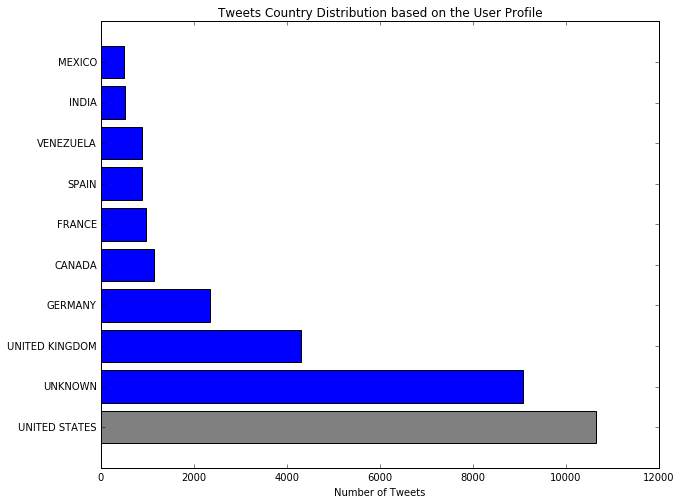

In [12]:
num_plotted_countries = 10

countries = p_df_cleaned_tweets_countries['USER_COUNTRY'][:num_plotted_countries]
num_tweets = p_df_cleaned_tweets_countries['NUM_TWEETS'][:num_plotted_countries]
y_pos = np.arange(len(countries))
colors = np.repeat('b', num_plotted_countries - 1).tolist()
colors = ['gray'] + colors

plt.figure(figsize=(10,8))
plt.barh(y_pos, num_tweets, align='center', color=colors)
plt.yticks(y_pos, countries)
plt.xlabel('Number of Tweets')
plt.title('Tweets Country Distribution based on the User Profile')
plt.ylim(-1, len(y_pos))

plt.show()

%%html
<div id="plot_div" style="width: 900px; height: 500px;"></div>

In [13]:
countries = p_df_cleaned_tweets_countries['USER_COUNTRY']
num_tweets = p_df_cleaned_tweets_countries['NUM_TWEETS']

data = "[['Country', 'Num Tweets']"
index = 0
for country in countries:
    country = country.replace("'", "")
    data = data + ", ['" + country + "', " + str(num_tweets[index]) + "]"
    index += 1
data = data + "]"

GeoChart(data, "'plot_div'")

<IPython.core.display.Javascript object>

As you won't need the data frames related to countries any longer run the following cell to clear the memory of those variables (both Spark and pandas).

In [14]:
df_cleaned_tweets_countries.unpersist()
df_cleaned_tweets_countries = None
p_df_cleaned_tweets_countries = None

# 6. Analyzing tweet sentiments

Sentiment analysis is one of the most valuable sources of information that the IBM twitter API provides. By giving each tweet a sentiment value, you can determine whether the content of a tweet is positive, negative, ambivalent, neutral, or NULL, if no value is provided by the API. Unfortunately, a sentiment value is provided for English, German, French, and Spanish tweets only. As the data set also has tweets in other languages, only a sub set of the tweets in the data set have a sentiment value.

The cells in the following section show you how to plot the sentiment values of all tweets in the data set. This is done by grouping tweets according to their sentiment value and then counting the number of tweets in each group.

After you have plotted the results, run the cell to release the memory of the variables you used.

In [15]:
#get number of tweets with P N U sentiment by grouping the sentiment value
tweets_grouped_by_sentiment = df_cleaned_tweets\
                .groupBy('SENTIMENT')\
                .agg(F.count('MESSAGE_ID').alias('NUM_TWEETS'))

tweets_grouped_by_sentiment.cache()
tweets_grouped_by_sentiment.show(5)

#move the results to pandas
p_tweets_grouped_by_sentiment = tweets_grouped_by_sentiment.toPandas()

+----------+----------+
| SENTIMENT|NUM_TWEETS|
+----------+----------+
|AMBIVALENT|      2098|
|  POSITIVE|     18654|
|  NEGATIVE|     13481|
+----------+----------+



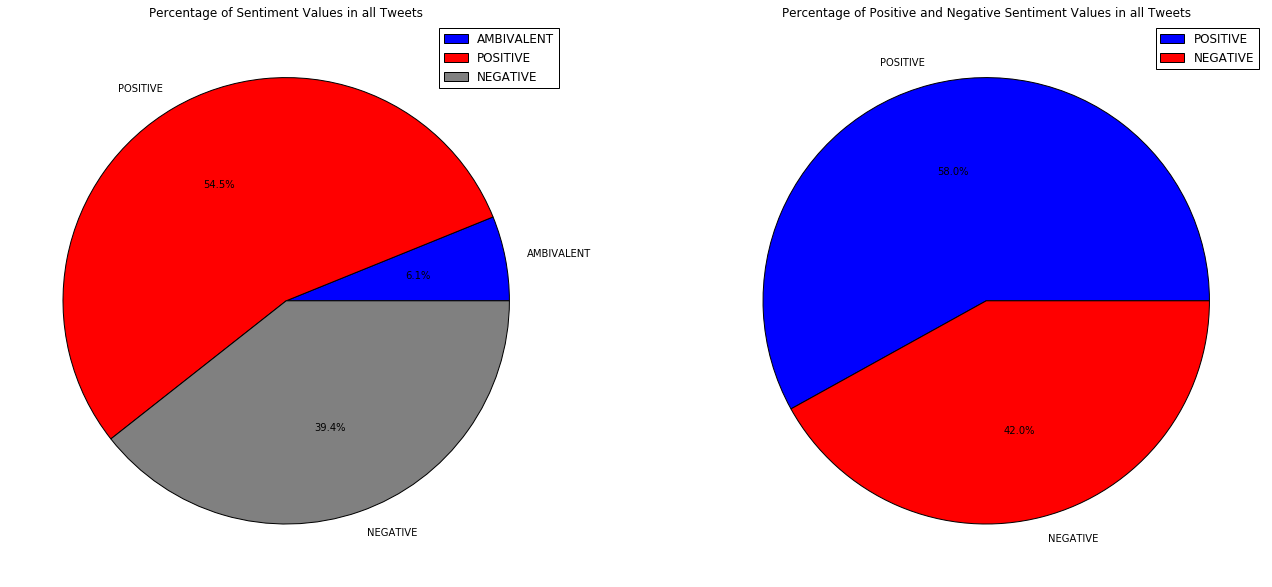

In [16]:
#data plot 1
plot1_labels = p_tweets_grouped_by_sentiment['SENTIMENT']
plot1_values = p_tweets_grouped_by_sentiment['NUM_TWEETS']
plot1_colors = ['blue', 'red', 'gray', 'yellow', 'green']

#data plot 2
cond1 = (p_tweets_grouped_by_sentiment['SENTIMENT'] == 'POSITIVE')
cond2 = (p_tweets_grouped_by_sentiment['SENTIMENT'] == 'NEGATIVE')

pMessage_sentiment_statistics_defined = p_tweets_grouped_by_sentiment[cond1 | cond2]
plot2_labels = pMessage_sentiment_statistics_defined['SENTIMENT']
plot2_values = pMessage_sentiment_statistics_defined['NUM_TWEETS']
plot2_colors = ['blue', 'red']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))

axes[0].pie(plot1_values,  labels=plot1_labels, colors=plot1_colors, autopct='%1.1f%%')
axes[0].set_title('Percentage of Sentiment Values in all Tweets')
axes[0].set_aspect('equal')
axes[0].legend(loc="upper right", labels=plot1_labels)

# Plot
axes[1].pie(plot2_values,  labels=plot2_labels, colors=plot2_colors, autopct='%1.1f%%')
axes[1].set_title('Percentage of Positive and Negative Sentiment Values in all Tweets')
axes[1].set_aspect('equal')
axes[1].legend(loc="upper right", labels=plot2_labels)

fig.subplots_adjust(hspace=1)
plt.show()

In [17]:
tweets_grouped_by_sentiment.unpersist()
tweets_grouped_by_sentiment = None
p_tweets_grouped_by_sentiment = None

# 7. Analyzing Twitter timelines

To learn more about which car manufacturing events occurred in 2015, you can plot data over time. The code cells in the following section group all tweets created in 2015 by their posting date (and the sentiment value) and counts the number of tweets per date.

In [18]:
#group by year-month-day and the sentiment
df_num_tweets_and_sentiment_over_time = df_cleaned_tweets.groupBy('POSTING_TIME', 'SENTIMENT')\
                    .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))\
                    .orderBy('POSTING_TIME', ascending=True)

#group by year-month-day
df_num_tweets_over_time = df_num_tweets_and_sentiment_over_time.groupBy('POSTING_TIME')\
                    .agg(F.sum('NUM_TWEETS').alias('NUM_TWEETS'))\
                    .orderBy('POSTING_TIME', ascending=True)

#move to Pandas
p_df_num_tweets_and_sentiment_over_time = df_num_tweets_and_sentiment_over_time.toPandas()
p_df_num_tweets_over_time = df_num_tweets_over_time.toPandas()

Run the next cell to prepare the data for plotting by moving data with different sentiment values into different data frames.

In [19]:
positive_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'POSITIVE'
negative_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'NEGATIVE'
neutral_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'NEUTRAL'
ambivalent_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'] == 'AMBIVALENT'
null_mask = p_df_num_tweets_and_sentiment_over_time['SENTIMENT'].isnull()

p_df_num_tweets_and_sentiment_over_time_positive = p_df_num_tweets_and_sentiment_over_time[positive_mask]
p_df_num_tweets_and_sentiment_over_time_negative = p_df_num_tweets_and_sentiment_over_time[negative_mask]
p_df_num_tweets_and_sentiment_over_time_neutral = p_df_num_tweets_and_sentiment_over_time[neutral_mask]
p_df_num_tweets_and_sentiment_over_time_ambivalent = p_df_num_tweets_and_sentiment_over_time[ambivalent_mask]
p_df_num_tweets_and_sentiment_over_time_null = p_df_num_tweets_and_sentiment_over_time[null_mask]

p_df_num_tweets_and_sentiment_over_time_positive = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_positive)
p_df_num_tweets_and_sentiment_over_time_negative = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_negative)
p_df_num_tweets_and_sentiment_over_time_neutral = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_neutral)
p_df_num_tweets_and_sentiment_over_time_ambivalent = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_ambivalent)
p_df_num_tweets_and_sentiment_over_time_null = addMissingDates(p_df_num_tweets_over_time, p_df_num_tweets_and_sentiment_over_time_null)

/usr/local/src/bluemix_jupyter_bundle.v4/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Run the next cell to plot your results after data munging. First plot the number of tweets about Volkswagen, Toyota, BMW, Daimler, and General Motors spread across 2015, then plot their positive and negative sentiment values, and lastly plot only the sentiment value applied to the number of tweets.

After you've completed plotting the results, clear the memory of the variables you used.

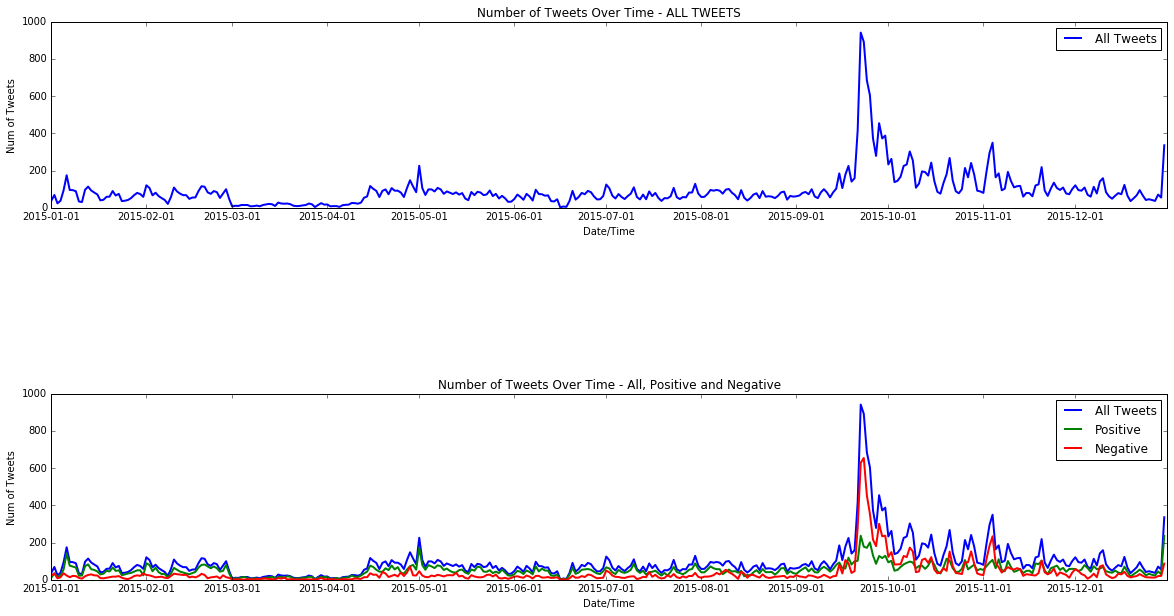

In [20]:
#take the beginning of each month
mask_1day = p_df_num_tweets_over_time['POSTING_TIME'].map(lambda x: x.day) == 1
x = p_df_num_tweets_over_time[mask_1day]['POSTING_TIME']
y = p_df_num_tweets_over_time['NUM_TWEETS']

#positive preparation
py = p_df_num_tweets_and_sentiment_over_time_positive['NUM_TWEETS']
#negative preparation
ny = p_df_num_tweets_and_sentiment_over_time_negative['NUM_TWEETS']
#undefined preparation
ney = p_df_num_tweets_and_sentiment_over_time_neutral['NUM_TWEETS']
#ambivalent preparation
ay = p_df_num_tweets_and_sentiment_over_time_ambivalent['NUM_TWEETS']
#null preparation - undefined
nully = p_df_num_tweets_and_sentiment_over_time_null['NUM_TWEETS']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

#plot1
axes[0].plot(range(len(y)), y, linewidth=2)
axes[0].set_xticks(x.index.tolist())
axes[0].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
axes[0].margins = 0
axes[0].set_xlabel('Date/Time')
axes[0].set_ylabel('Num of Tweets')
axes[0].set_title('Number of Tweets Over Time - ALL TWEETS')
axes[0].set_xlim(0, len(y))
axes[0].legend(loc="upper right", labels=['All Tweets'])
#axes[0].axhline(y=12700, c="red")

axes[1].plot(range(len(y)), y, linewidth=2, color='blue')
axes[1].plot(range(len(py)), py, linewidth=2, color='green')
axes[1].plot(range(len(ny)), ny, linewidth=2, color='red')

axes[1].set_xticks(x.index.tolist())
axes[1].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
axes[1].margins = 0
axes[1].set_xlabel('Date/Time')
axes[1].set_ylabel('Num of Tweets')
axes[1].set_title('Number of Tweets Over Time - All, Positive and Negative')
axes[1].set_xlim(0, len(y))
axes[1].legend(loc="upper right", labels=['All Tweets', 'Positive', 'Negative', 'Undefined Sentiment'])

fig.subplots_adjust(hspace=1)
plt.show()

In [21]:
df_num_tweets_and_sentiment_over_time.unpersist()
df_num_tweets_over_time.unpersist()

df_num_tweets_and_sentiment_over_time = None
df_num_tweets_over_time = None

p_df_num_tweets_and_sentiment_over_time = None
#we will need the variable p_df_num_tweets_over_time

p_df_num_tweets_and_sentiment_over_time_positive = None
p_df_num_tweets_and_sentiment_over_time_negative = None
p_df_num_tweets_and_sentiment_over_time_neutral = None
p_df_num_tweets_and_sentiment_over_time_ambivalent = None
p_df_num_tweets_and_sentiment_over_time_null = None

## 8. Drawing insights from tweets about car manufacturers

This section combines different types of analyses to dig deeper into the list of car manufacturers (Volkswagen, Toyota, BMW, Daimler, and  General Motors). The purpse of the analyses is to obtain car manufacturer-based insights from tweets that could be interesting and useful to detect potential car buyers. 

The first step is to detect the tweets that mention certain car manufacturers. Run the next cell to munge the data into a new data frame that has additional columns for each car manufacturer. The value in this column in each row indicates whether the car company was mentioned in a tweet or not. 

This new data frame is the new data source for subsequent computations in this section.

In [22]:
def hasWord(message, word):
    return (word in message)

def checkCarMaker(message):
    tmp = []
    for car_maker_list_var in car_makers_list:
        contain = False
        for car_maker in car_maker_list_var:
            if (hasWord(message, car_maker)):
                contain = True
        tmp.extend([contain])
    return tmp

def checkCarFeatures(message, feature_list):
    tmp = []    
    contain = False
    for term in feature_list:
        if (hasWord(message, term.decode('utf8'))):
            contain = True
    tmp.extend([contain])
    return tmp

def getInfluence(tweet):
    return ((tweet.USER_FOLLOWERS_COUNT + tweet.USER_FRIENDS_COUNT) / 2)

def getAllAttributes(tweet):
    message = unicode(tweet.MESSAGE_BODY).lower()
    
    #message id and line
    tmp = [tweet.MESSAGE_ID, tweet.MESSAGE_BODY, tweet.SENTIMENT, tweet.USER_GENDER, unicode(tweet.USER_COUNTRY).upper()\
               , tweet.POSTING_TIME, getInfluence(tweet)]

    #competitors in line
    tmp.extend(checkCarMaker(message))
    
    #electric cars - autodrive cars
    tmp.extend(checkCarFeatures(message, electric_vehicle_terms))
    tmp.extend(checkCarFeatures(message, auto_driver_terms))
    
    return tmp

columns_names = ['MESSAGE_ID', 'MESSAGE_BODY', 'SENTIMENT', 'USER_GENDER', 'USER_COUNTRY', 'POSTING_TIME', 'INFLUENCE']
for carMakerName in car_makers_name_list:
        columns_names.append(carMakerName)
columns_names.append('ELECTRIC_CARS')
columns_names.append('AUTO_DRIVE')

df_tweets_car_maker = sqlContext.createDataFrame(df_cleaned_tweets
                             .map(lambda x: getAllAttributes(x)), columns_names)

df_tweets_car_maker.cache()
df_tweets_car_maker.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- SENTIMENT: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_COUNTRY: string (nullable = true)
 |-- POSTING_TIME: timestamp (nullable = true)
 |-- INFLUENCE: double (nullable = true)
 |-- BMW: boolean (nullable = true)
 |-- DAIMLER: boolean (nullable = true)
 |-- GM: boolean (nullable = true)
 |-- TESLA: boolean (nullable = true)
 |-- TOYOTA: boolean (nullable = true)
 |-- VW: boolean (nullable = true)
 |-- ELECTRIC_CARS: boolean (nullable = true)
 |-- AUTO_DRIVE: boolean (nullable = true)



## Analyzing Twitter timelines


You will plot the data over time according to each car manufacturer. This can be done by using the Spark data frame that you just constructed. You will filter the data by each car maker and then regroup the resulting data frame according to the posting time of the tweets.

In [23]:
print 'Calculating the number of tweets over 2015 for each car maker:'

car_maker_results_list = []
for car_maker in car_makers_name_list:
    #get competitor dataframe
    df_car_maker = df_tweets_car_maker.filter(df_tweets_car_maker[car_maker] == True)
    overall_car_maker_time_data = df_car_maker.groupBy('POSTING_TIME')\
                        .agg(F.count('MESSAGE_ID').alias('COUNT'))\
                        .orderBy('POSTING_TIME' , ascending=True)

    p_overall_car_maker_time_data = overall_car_maker_time_data.toPandas()
    car_maker_results_list.append(p_overall_car_maker_time_data)
    
    overall_car_maker_time_data.unpersist()
    print 'Done for ' + car_maker

Calculating the number of tweets over 2015 for each car maker:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


The plot shows the distribution of tweets about Volkswagen, Toyota, BMW, Daimler, and  General Motors in 2015 based on the tweet posting dates.

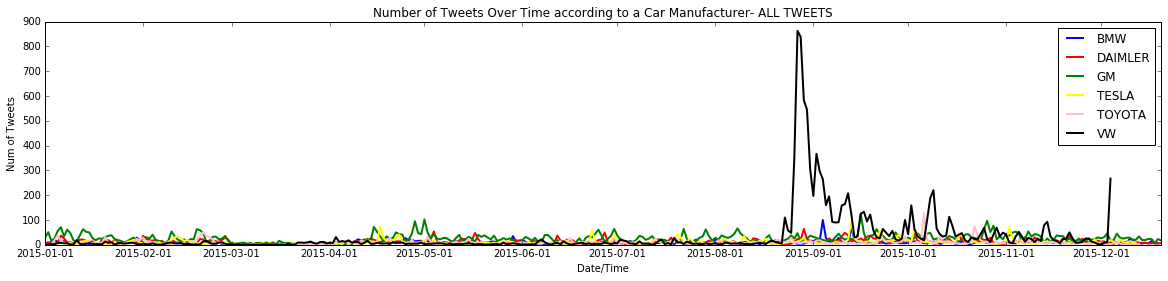

In [24]:
mask_1day = p_df_num_tweets_over_time['POSTING_TIME'].map(lambda x: x.day) == 1
x = p_df_num_tweets_over_time[mask_1day]['POSTING_TIME']

#plotting
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
colors = ['blue', 'red', 'green', 'yellow', 'pink', 'black']

for i in range(0, len(car_makers_name_list)):
    y = car_maker_results_list[i]['COUNT']
    axes.plot(range(len(y)), y, linewidth=2, color=colors[i])

axes.set_xticks(x.index.tolist())
axes.set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
axes.margins = 0
axes.set_xlabel('Date/Time')
axes.set_ylabel('Num of Tweets')
axes.set_title('Number of Tweets Over Time according to a Car Manufacturer- ALL TWEETS')
axes.set_xlim(0, len(car_maker_results_list[0]))
axes.legend(loc="upper right", labels=car_makers_name_list)

fig.subplots_adjust(hspace=1)
plt.show()

## Discover insight explaining the peak of tweets for VW between September 15 and October 15 2015

In [25]:
df_tweets_debacle = df_tweets_car_maker.filter((df_tweets_car_maker["VW"] == True) &\
                   (df_tweets_car_maker.POSTING_TIME > '2015-09-15 0.0.0') & \
                   (df_tweets_car_maker.POSTING_TIME < '2015-10-15 0.0.0'))
df_tweets_debacle.count()

6553

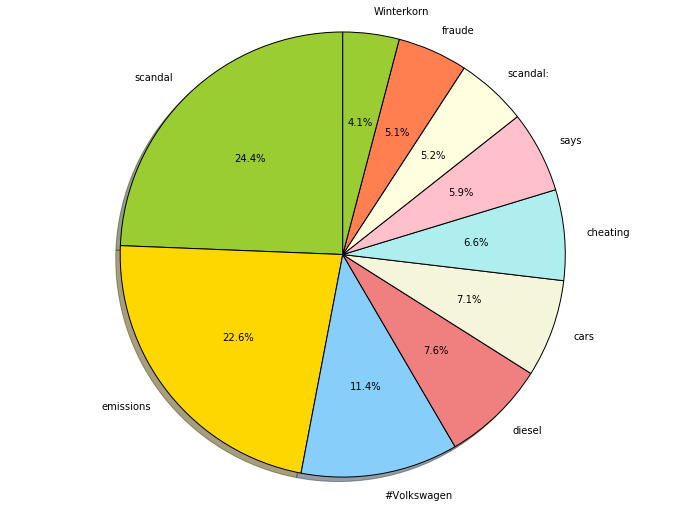

In [26]:
from operator import add
import re
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
cachedStopWords.extend(["Volkswagen","VW","de","el","que","en"])

tagsRDD = df_tweets_debacle.flatMap( lambda t: re.split("\s", t.MESSAGE_BODY))\
    .filter( lambda word: not word.startswith("http") and all(ord(c) < 128 for c in word) and word not in cachedStopWords and len(word)>3)\
    .map( lambda word : (word, 1 ))\
    .reduceByKey(add, 10).map(lambda (a,b): (b,a)).sortByKey(False).map(lambda (a,b):(b,a))
top10tags = tagsRDD.take(10)

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )

labels = [i[0] for i in top10tags]
sizes = [int(i[1]) for i in top10tags]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "beige", "paleturquoise", "pink", "lightyellow", "coral"]

plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

In [27]:
car_maker_results_list = []

## Adding sentiment analysis

Next extend your analysis and plot results that combine posting time and sentiment change in tweets in 2015. 
Any positive or negative peaks correspond to events that occurred in the car company at a certain time.

In [28]:
print 'Calculating the number of positive and negative tweets over 2015 for each car maker:'

car_maker_results_list = []
for car_maker in car_makers_name_list:
    #get competitor dataframe
    df_car_maker = df_tweets_car_maker.filter(df_tweets_car_maker[car_maker] == True)
    
    time_sentiment_car_maker_data = df_car_maker.groupBy('POSTING_TIME', 'SENTIMENT')\
                                        .agg(F.count('MESSAGE_ID').alias('COUNT'))\
                                        .orderBy('POSTING_TIME', ascending=True)
    
    time_sentiment_car_maker_data.cache()
    
    time_positive_sentiment_car_maker_data = time_sentiment_car_maker_data.filter(time_sentiment_car_maker_data['SENTIMENT'] == 'POSITIVE')
    time_negative_sentiment_car_maker_data = time_sentiment_car_maker_data.filter(time_sentiment_car_maker_data['SENTIMENT'] == 'NEGATIVE')

    p_time_positive_sentiment_car_maker_data = time_positive_sentiment_car_maker_data.toPandas()
    p_time_negative_sentiment_car_maker_data = time_negative_sentiment_car_maker_data.toPandas()
    
    #collect results
    car_maker_results_list.append([p_time_positive_sentiment_car_maker_data, p_time_negative_sentiment_car_maker_data])
    time_sentiment_car_maker_data.unpersist()
    print 'Done for ' + car_maker

Calculating the number of positive and negative tweets over 2015 for each car maker:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


/usr/local/src/bluemix_jupyter_bundle.v4/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


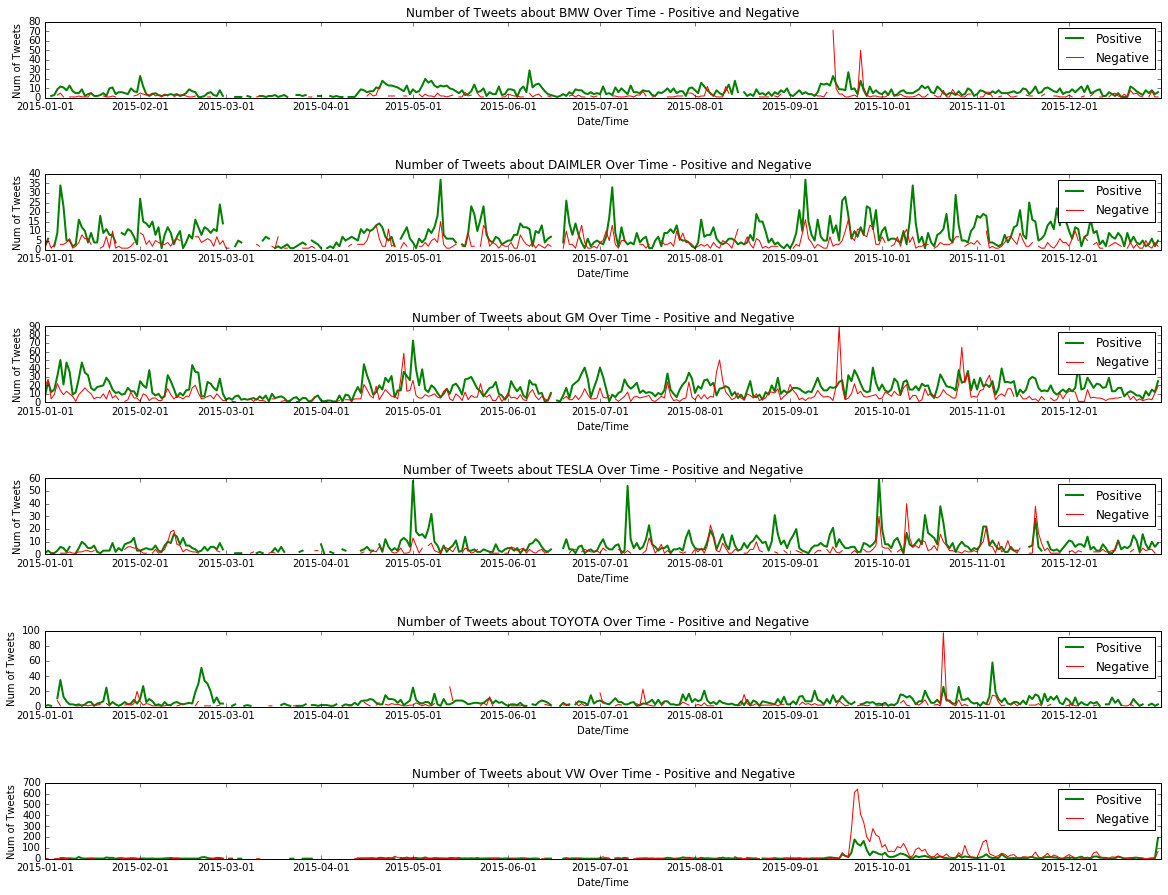

In [29]:
mask_1day = p_df_num_tweets_over_time['POSTING_TIME'].map(lambda x: x.day) == 1
x = p_df_num_tweets_over_time[mask_1day]['POSTING_TIME']

for i in range(0, len(car_makers_name_list)):
    car_maker_results_list[i][0] = addMissingDates(p_df_num_tweets_over_time, car_maker_results_list[i][0])
    car_maker_results_list[i][1] = addMissingDates(p_df_num_tweets_over_time, car_maker_results_list[i][1])

fig, axes = plt.subplots(nrows=len(car_maker_results_list), ncols=1, figsize=(20, 15))
colors = ['blue', 'red', 'green', 'yellow', 'black']

for i in range(0, len(car_makers_name_list)):
    y1 = car_maker_results_list[i][0]['COUNT']
    y2 = car_maker_results_list[i][1]['COUNT']
    
    axes[i].plot(range(len(y1)), y1, linewidth=2, color='green')
    axes[i].plot(range(len(y2)), y2, linewidth=1, color='red')
    axes[i].set_xticks(x.index.tolist())
    axes[i].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
    axes[i].margins = 0
    axes[i].set_xlabel('Date/Time')
    axes[i].set_ylabel('Num of Tweets')
    axes[i].set_title('Number of Tweets about ' + car_makers_name_list[i] + ' Over Time - Positive and Negative')
    axes[i].set_xlim(0, len(car_maker_results_list[0][0]))
    axes[i].legend(loc="upper right", labels=['Positive', 'Negative'])

fig.subplots_adjust(hspace=1)
plt.show()

## Calculating the number of tweets across car manufacturers

The next code cells calculate the number of tweets about certain car manufacturers and then plot the resulting numbers in a bar chart and as percentages in a pie chart. 

In [30]:
print 'Calculating the number of tweets that mention one of the car makers:'

car_maker_tweets_count = []
for car_maker in car_makers_name_list:
    df_car_maker = df_tweets_car_maker.filter(df_tweets_car_maker[car_maker] == True)
    car_maker_tweets_count.append(df_car_maker.count())
    print 'Done for ' + car_maker

Calculating the number of tweets that mention one of the car makers:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


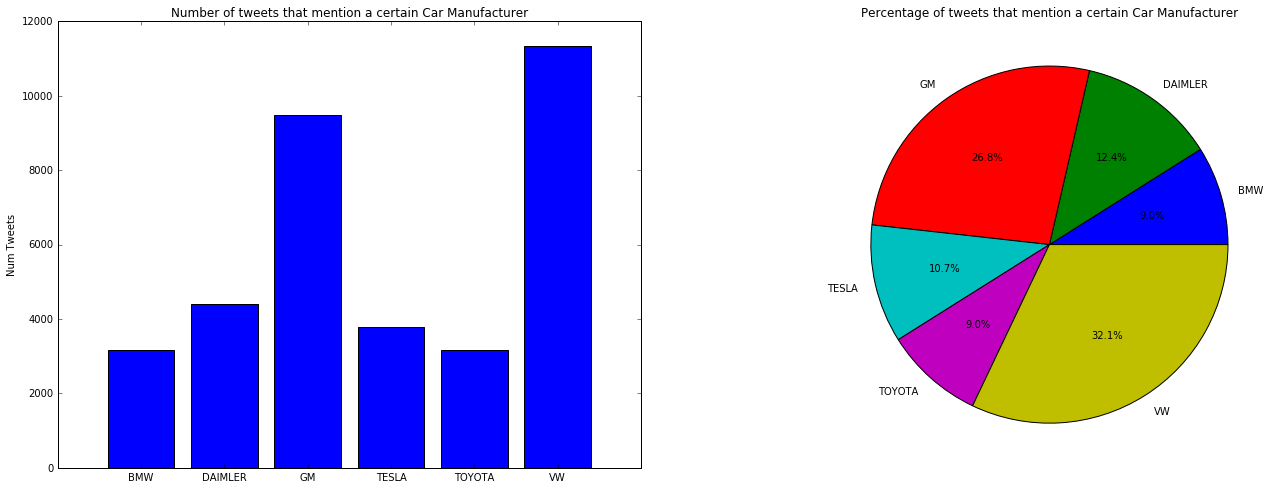

In [31]:
#plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 8))

axes[0].bar(ind, car_maker_tweets_count, width, color='b', align='center')
axes[0].set_ylabel('Num Tweets')
axes[0].set_title('Number of tweets that mention a certain Car Manufacturer')
axes[0].set_xticks(ind)
axes[0].set_xticklabels(car_makers_name_list)

# Plot
axes[1].pie(car_maker_tweets_count,autopct='%1.1f%%', labels=car_makers_name_list)
axes[1].set_aspect('equal')
axes[1].set_title('Percentage of tweets that mention a certain Car Manufacturer')

fig.subplots_adjust(hspace=1)
plt.show()

# Calculating the distribution of positive and negative tweets

To determine the distribution of sentiment values of the tweets for each car manufacturers, run the next cell to calculate the number of positive and negative tweets across car makers and plot the results next to each other.

In [32]:
positive_sum_car_makers = []
negative_sum_car_makers = []

for i in range(0, len(car_makers_name_list)):
    car_maker = car_makers_name_list[i]
    car_maker_results_list[i][0] = car_maker_results_list[i][0].fillna(0)
    car_maker_results_list[i][1] = car_maker_results_list[i][1].fillna(0)
    positive_sum_car_makers.extend([car_maker_results_list[i][0]['COUNT'].sum()])
    negative_sum_car_makers.extend([car_maker_results_list[i][1]['COUNT'].sum()])

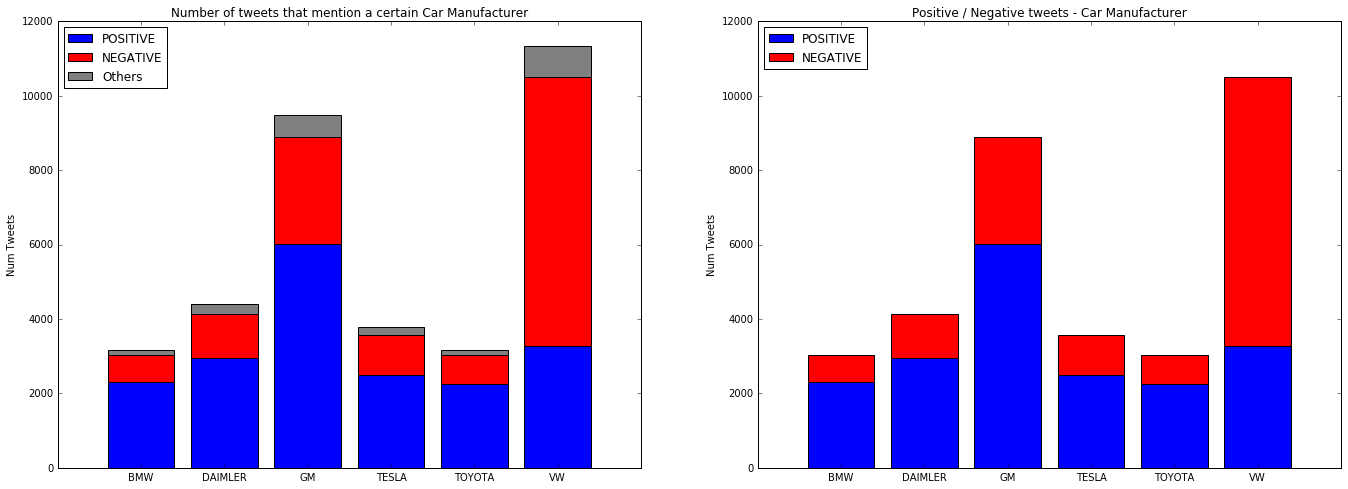

In [33]:
sum_value_P_N = np.add(positive_sum_car_makers, negative_sum_car_makers)
competitors_list_rest = np.subtract(car_maker_tweets_count, sum_value_P_N)

#plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 8))

#axes[0].bar(ind, competitors_list, width, color='b', align='center')
axes[0].bar(ind, positive_sum_car_makers, width, color='b', align='center')
axes[0].bar(ind, negative_sum_car_makers, width, color='r', bottom=positive_sum_car_makers, align='center')
axes[0].bar(ind, competitors_list_rest, width, color='gray', align='center',bottom=sum_value_P_N)
axes[0].set_ylabel('Num Tweets')
axes[0].set_title('Number of tweets that mention a certain Car Manufacturer')
axes[0].set_xticks(ind)
axes[0].set_xticklabels(car_makers_name_list)
axes[0].legend(loc="upper left", labels=['POSITIVE', 'NEGATIVE', 'Others'])

axes[1].bar(ind, positive_sum_car_makers, width, color='b', align='center')
axes[1].bar(ind, negative_sum_car_makers, width, color='r', bottom=positive_sum_car_makers, align='center')
axes[1].set_ylabel('Num Tweets')
axes[1].set_title('Positive / Negative tweets - Car Manufacturer')
axes[1].set_xticks(ind)
axes[1].set_xticklabels(car_makers_name_list)
axes[1].legend(loc="upper left", labels=['POSITIVE', 'NEGATIVE'])

fig.subplots_adjust(hspace=1)
plt.show()

The plots show that in general there are more positive than negative tweets.

## Determining gender distribution 

Another interesting insight when analyzing tweets about certain car manufacturers and what car manufacturers might want to pay more attention to for marketing purposes is the distribution of tweets between male and female users. 

The following cells calculate the gender distribution across each competitor and plot the results. 

In [34]:
print 'Calculating the distribution of male and female in tweets over 2015 for each competitors:'

car_maker_info_list_M_F = []

for car_maker in car_makers_name_list:
    df_car_maker = df_tweets_car_maker.filter(df_tweets_car_maker[car_maker] == True)
    car_maker_gender_data = df_car_maker.groupBy('USER_GENDER')\
                                .agg(F.count('MESSAGE_ID').alias('COUNT'))
    car_maker_gender_data.cache()

    p_car_maker_gender_data_male = car_maker_gender_data.filter(car_maker_gender_data['USER_GENDER'] == 'male').toPandas()
    p_car_maker_gender_data_female = car_maker_gender_data.filter(car_maker_gender_data['USER_GENDER'] == 'female').toPandas()
    car_maker_info_list_M_F.append([p_car_maker_gender_data_male, p_car_maker_gender_data_female])    
    car_maker_gender_data.unpersist()
    print 'Done for ' + car_maker

Calculating the distribution of male and female in tweets over 2015 for each competitors:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


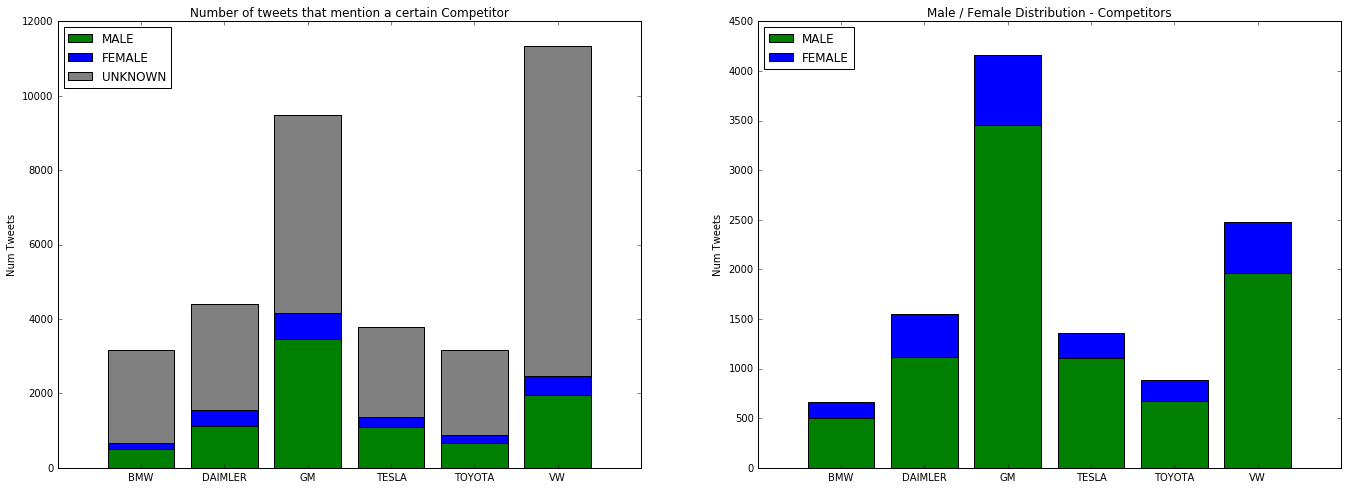

In [35]:
#prepare data for plotting
car_maker_list_female = []
car_maker_list_male = []
for i in range(0, len(car_maker_info_list_M_F)):
    car_maker_list_female.append(0 if car_maker_info_list_M_F[i][1]['COUNT'].empty else car_maker_info_list_M_F[i][1]['COUNT'][0])
    car_maker_list_male.append(0 if car_maker_info_list_M_F[i][0]['COUNT'].empty else car_maker_info_list_M_F[i][0]['COUNT'][0])

sum_value_M_F = np.add(car_maker_list_male, car_maker_list_female)
car_maker_list_M_F_rest = np.subtract(car_maker_tweets_count, sum_value_M_F)

#plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 8))

axes[0].bar(ind, car_maker_list_male, width, color='g', align='center')
axes[0].bar(ind, car_maker_list_female, width, color='b',bottom=car_maker_list_male, align='center')
axes[0].bar(ind, car_maker_list_M_F_rest, width, color='gray', align='center',bottom=sum_value_M_F)
axes[0].set_ylabel('Num Tweets')
axes[0].set_title('Number of tweets that mention a certain Competitor')
axes[0].set_xticks(ind)
axes[0].set_xticklabels(car_makers_name_list)
axes[0].legend(loc="upper left", labels=['MALE', 'FEMALE', 'UNKNOWN'])

axes[1].bar(ind, car_maker_list_male, width, color='g', align='center')
axes[1].bar(ind, car_maker_list_female, width, color='b',bottom=car_maker_list_male, align='center')
axes[1].set_ylabel('Num Tweets')
axes[1].set_title('Male / Female Distribution - Competitors')
axes[1].set_xticks(ind)
axes[1].set_xticklabels(car_makers_name_list)
axes[1].legend(loc="upper left", labels=['MALE', 'FEMALE'])

fig.subplots_adjust(hspace=1)
plt.show()

It can be seen in the plotted results that in general, men post more tweets about cars than women do.

## Measuring influence

In this section, we will calculate the average value of the influence variable of the people who tweeted about a certain car maker. The influence varable is calculated by: 

$$Influence = ( \space num \space of \space followers + \space number \space of \space friends \space ) \div 2$$


The influence score gives an indication whether someone is a famous person or a public figure in society or whether the twitter account is owned by the media or a company. This average value gives an indication about the people who are interested in a certain car maker.


In [36]:
#returns a list of pandas DFs.
def getInsights_Influence(sparkDF,car_maker_list):
    print 'Calculating the influence insight of the users in tweets over 2015 for each competitors:'

    car_maker_result_list = []
    for car_maker in car_maker_list:
        df_car_maker = sparkDF.filter(sparkDF[car_maker] == True)
        car_maker_insight_data = df_car_maker.select(F.avg('INFLUENCE').alias('AVE_INFLUENCE'))
        car_maker_result_list.append(car_maker_insight_data.toPandas())
        df_car_maker.unpersist()
        car_maker_insight_data.unpersist()
        print 'Done for ' + car_maker
    return car_maker_result_list

In [37]:
influenceInsights = getInsights_Influence(df_tweets_car_maker, car_makers_name_list)

Calculating the influence insight of the users in tweets over 2015 for each competitors:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


In [38]:
influence_list = []
for i in range(0, len(car_makers_name_list)):
    influence_list.append(influenceInsights[i]['AVE_INFLUENCE'][0])

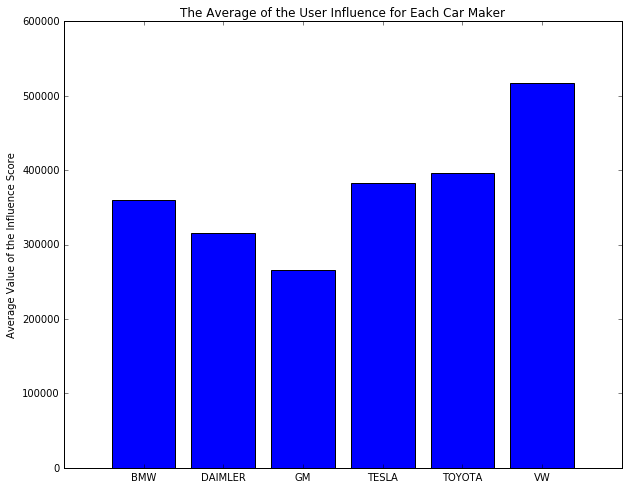

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

rects = axes.bar(ind, influence_list, width, color='b', align='center')
axes.set_ylabel('Average Value of the Influence Score')

#influence=(number of friends + number of followers)/2
axes.set_title('The Average of the User Influence for Each Car Maker')
axes.set_xticks(ind)
axes.set_xticklabels(car_makers_name_list)

fig.subplots_adjust(hspace=1)
plt.show()

In [40]:
influenceInsights = None

## Determining the distribution of tweets by country across car manufacturer

The next cells calculate in which countries the most tweets were posted about car manufacturers. This information can support marketing and sales when evaluating potential customers.

In [41]:
print 'Calculating the country distribution of tweets over 2015 for each car maker:'

car_maker_info_list_countries = []
i = 0

for car_maker in car_makers_name_list:
    df_car_maker = df_tweets_car_maker.filter(df_tweets_car_maker[car_maker] == True)
    car_maker_country_data = df_car_maker.groupBy('USER_COUNTRY')\
                                .agg(F.count('MESSAGE_ID').alias('COUNT'))\
                                .orderBy('COUNT', ascending=False)
    car_maker_country_data.cache()

    p_car_maker_country_data = car_maker_country_data.toPandas()
    car_maker_info_list_countries.append(p_car_maker_country_data)
    car_maker_country_data.unpersist()
    print 'Done for ' + car_maker

Calculating the country distribution of tweets over 2015 for each car maker:
Done for BMW
Done for DAIMLER
Done for GM
Done for TESLA
Done for TOYOTA
Done for VW


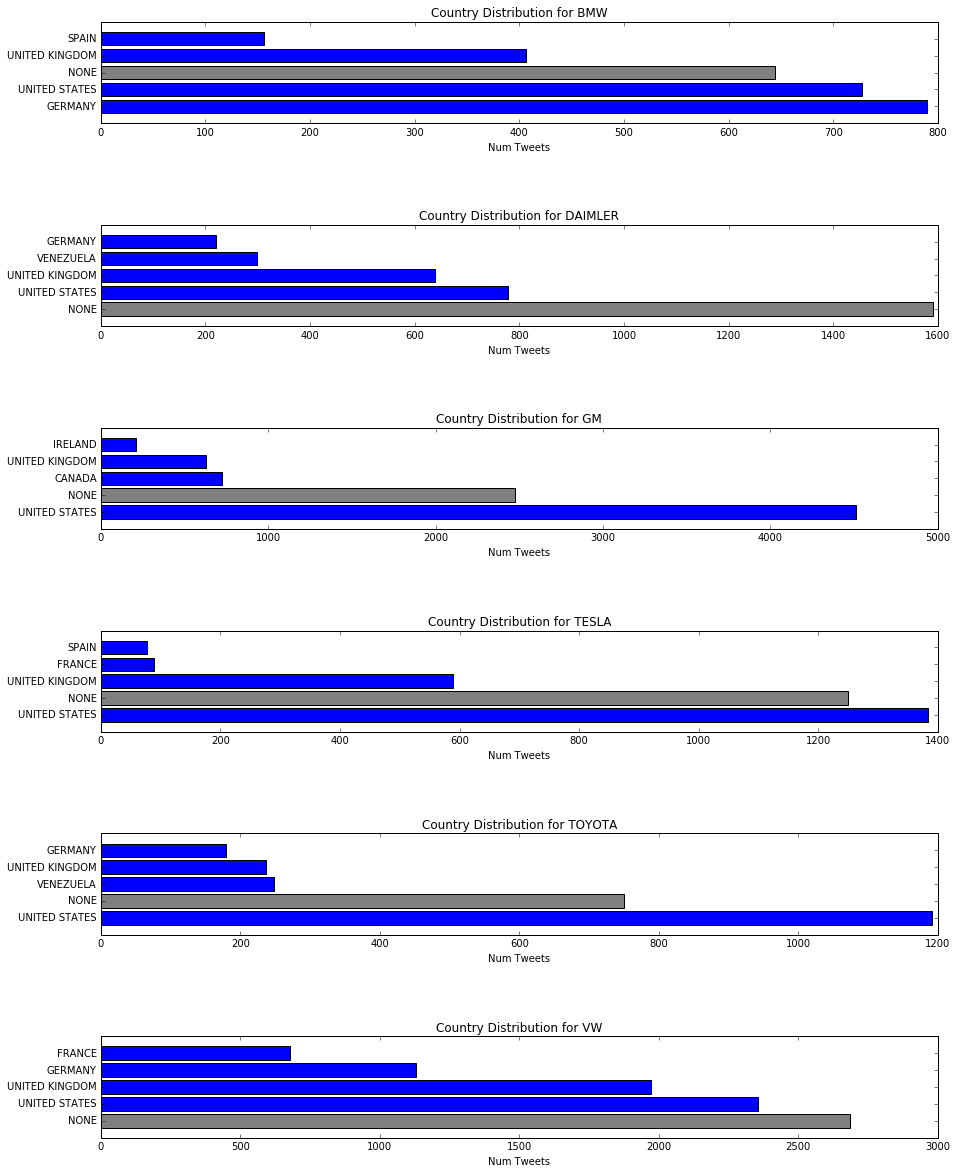

In [42]:
num_taken_countries = 5

#plot
fig, axes = plt.subplots(nrows=len(car_makers_name_list), ncols=1, figsize=(15, 20))


for j in range(0, len(car_makers_name_list)):
    color = 'b'#np.random.rand(3,1)
    colors = np.repeat(color, num_taken_countries).tolist()
    
    country_list_num = car_maker_info_list_countries[j]['COUNT'][:num_taken_countries]
    country_list_labels = car_maker_info_list_countries[j]['USER_COUNTRY'][:num_taken_countries]
    
    for counter in range(0, len(country_list_labels)):
        if (country_list_labels[counter] == 'NONE'):
            colors[counter] = 'gray'

    axes[j].barh(np.arange(num_taken_countries), country_list_num, width, color=colors, align='center')
    axes[j].set_xlabel('Num Tweets')
    axes[j].set_title('Country Distribution for ' + car_makers_name_list[j])
    axes[j].set_yticks(ind)
    axes[j].set_yticklabels(country_list_labels.tolist())
    
fig.subplots_adjust(hspace=1)
plt.show()

The plots above show the countries with the highest number of tweets about one car maker. You can also calculate the distribution of tweets about all of the car makers for one country and compare countries. Run the following cells to compare these results for the US, UK and Germany.

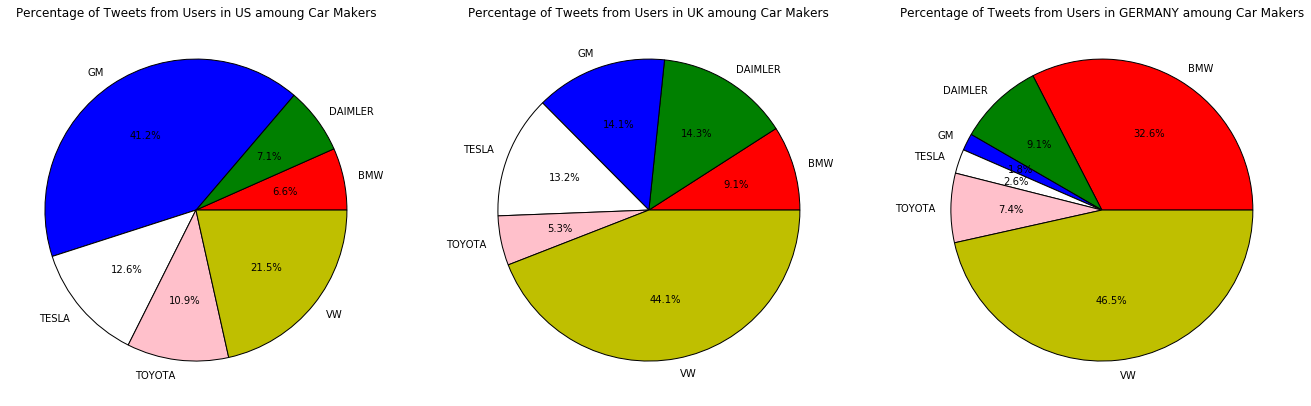

In [43]:
#plot for each country
us_list = []
uk_list = []
de_list = []
def getListForCountry(x, country):
    df=x[x['USER_COUNTRY'] == country]['COUNT']
    return [0] if df.empty else [df.tolist()[0]]    

for i in range(0, len(car_makers_name_list)):
    x = car_maker_info_list_countries[i]
    us_list.extend(getListForCountry(x, 'UNITED STATES'))
    uk_list.extend(getListForCountry(x, 'UNITED KINGDOM'))
    de_list.extend(getListForCountry(x, 'GERMANY'))

#plot
colors = ['r', 'g', 'b', 'w', 'pink', 'y']
us_values = us_list
uk_values = uk_list
de_values = de_list

#plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 10))

axes[0].pie(us_values,autopct='%1.1f%%', colors=colors, labels=car_makers_name_list)
axes[0].set_aspect('equal')
axes[0].set_title('Percentage of Tweets from Users in US amoung Car Makers')

# Plot
axes[1].pie(uk_values,autopct='%1.1f%%', colors=colors, labels=car_makers_name_list)
axes[1].set_aspect('equal')
axes[1].set_title('Percentage of Tweets from Users in UK amoung Car Makers')

# Plot
axes[2].pie(de_values,autopct='%1.1f%%', colors=colors, labels=car_makers_name_list)
axes[2].set_aspect('equal')
axes[2].set_title('Percentage of Tweets from Users in GERMANY amoung Car Makers')

fig.subplots_adjust(hspace=1)
plt.show()

# 9. Draw insights about car features

In this section, you will analysis the data set to extract insights about car features, for example information about electric cars and self-driving cars.


## Helper functions

In [44]:
def getCountryDistribution(df):
    df_cleaned_tweets_countries = df.groupBy('USER_COUNTRY')\
                .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))\
                .orderBy('NUM_TWEETS', ascending=False)
    return df_cleaned_tweets_countries.toPandas()

def PlotCountryDistribution(pdf, num_plotted_countries, title):
    countries = pdf['USER_COUNTRY'][:num_plotted_countries]
    num_tweets = pdf['NUM_TWEETS'][:num_plotted_countries]
    y_pos = np.arange(len(countries))
    colors = np.repeat('b', num_plotted_countries - 1).tolist()
    colors = ['gray'] + colors

    plt.figure(figsize=(10,8))
    plt.barh(y_pos, num_tweets, align='center', color=colors)
    plt.yticks(y_pos, countries)
    plt.xlabel('Number of Tweets')
    plt.title(title)
    plt.ylim(-1, len(y_pos))
    plt.show()

#sentiment functions
#the dataframe should have the columns Sentiment, MESSAGE_ID
def getGeneralSentiment(df):
    #get number of tweets with P N U sentiment by grouping the sentiment value
    df_grouped_by_sentiment = df\
                            .groupBy('SENTIMENT')\
                            .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))

    #move the results to pandas
    return df_grouped_by_sentiment.toPandas()


#it returns a list which contains a sequence of element. Each element is a list of integer values. Those values are:
#total count, male count, female count, positive count, negative count
def getCarMaker_Gender_Sentiment_Analysis(df):
    final_result_list = []
    for car_maker in car_makers_name_list:
        result_carMaker_list = []
        
        df_car_maker = df.filter(df[car_maker] == True)
        result_carMaker_list.append(df_car_maker.count())#total count for a car maker        
        df_car_maker_male = df_car_maker.filter(df.USER_GENDER == 'male')
        result_carMaker_list.append(df_car_maker_male.count())#male count        
        df_car_maker_female = df_car_maker.filter(df.USER_GENDER == 'female')
        result_carMaker_list.append(df_car_maker_female.count())#female count        
        df_car_maker_male.unpersist()
        df_car_maker_female.unpersist()        
        df_sentiment = df_car_maker.groupBy('SENTIMENT')\
                    .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))
        
        result_carMaker_list.append(df_sentiment.toPandas())#positive count        
        df_sentiment.unpersist()
        final_result_list.append(result_carMaker_list)
        print 'Done calculation for ' + car_maker
    return final_result_list

def BarPlot(axes, values, title, ytitle, xlabels):
    rects = axes.bar(ind, values, width, color='b', align='center')
    axes.set_ylabel(ytitle)
    axes.set_title(title)
    axes.set_xticks(ind)
    axes.set_xticklabels(xlabels)

def getPercentag(total, portion):
    return 0 if total==0 else (portion*100) / total

def getMaleFemaleDistribution(df):
    df_grouped_by_gender = df\
            .groupBy('USER_GENDER')\
            .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))    
    return df_grouped_by_gender.toPandas()

    
def Plot_PieChart(pdf, labels_column, values_column, axes, title, plot1_colors):
    plot1_labels = map(lambda x:str(x).upper(), pdf[labels_column])
    plot1_values = pdf[values_column]
    
    axes.pie(plot1_values,  labels=plot1_labels, colors=plot1_colors, autopct='%1.1f%%')
    axes.set_title(title)
    axes.set_aspect('equal')
    axes.legend(loc="upper right", labels=plot1_labels)    
    
#data_list: data to plot has the strucutre: [[list values 1], [list values 2], [list values 3]]
def plotHorBarPercentage(axes, data_list, title_string, xtitle, ylabels, color_list, legend_labels):
    y_pos = np.arange(len(data_list[0]))
    
    for i in range(0, len(data_list)):
        if (i == 0):
            rects = axes.barh(y_pos, data_list[i], align='center', color=color_list[i])
            counter = 0
            for rect in rects:
                axes.text(rect.get_width()/2., rect.get_y() + rect.get_height()/3.,
                        '%.1f' % data_list[i][counter] + '%',
                        ha='center', va='bottom')
                counter += 1
        else:
            old_value = np.zeros(len(data_list[0])).tolist()
            for j in range(0, i):
                old_value = [x[0]+x[1] for x in zip(old_value, data_list[j])]
            rects = axes.barh(y_pos, data_list[i], align='center', color=color_list[i], left=old_value)
            
            counter = 0
            for rect in rects:
                axes.text(rect.get_width()/2. + rect.get_x(), rect.get_y() + rect.get_height()/3.,
                        '%.1f' % data_list[i][counter] + '%',
                        ha='center', va='bottom')
                counter += 1
    axes.set_yticks(y_pos)
    axes.set_yticklabels(ylabels)
    axes.set_xlabel(xtitle)
    axes.set_title(title_string)
    axes.set_ylim(-1, len(y_pos))
    axes.set_xlim(0, 100)
    axes.legend(loc="upper center", labels=legend_labels, ncol=len(legend_labels))

## Draw insights about electric cars

Some customers are looking to buy an electric vehicle to help save gasoline and protect the environment. For this reason, many car manufacturers have moved to producing electric cars. In this section, you will analyze tweets, which mention electric cars. To find these tweets, you need to search for certain words inside the tweet text such as electric cars, electric motors, etc. The sample uses the search terms in the list called "electric_vehicle_terms" to find matches. The list contains terms in four languages, namely in English, French, German, and Spanish.

In this section, you will use the the constructed data frame called "df_tweets_car_maker". This data frame has a column named ELECTRIC_CARS which indicates whether electric cars were mentioned in a tweet or not. Run the next cell to filter the data according to the value of this column.

In [45]:
df_electric_cars = df_tweets_car_maker.filter(df_tweets_car_maker.ELECTRIC_CARS == True)
df_electric_cars.cache()

DataFrame[MESSAGE_ID: string, MESSAGE_BODY: string, SENTIMENT: string, USER_GENDER: string, USER_COUNTRY: string, POSTING_TIME: timestamp, INFLUENCE: double, BMW: boolean, DAIMLER: boolean, GM: boolean, TESLA: boolean, TOYOTA: boolean, VW: boolean, ELECTRIC_CARS: boolean, AUTO_DRIVE: boolean]

Run the next cell to calculate the number of tweets that speak about electic cars.

In [46]:
df_electric_cars.count()

191

### Calculating the country distribution of electric car tweets

In this section, you will find the top ten countries with the highest number of tweets about electric cars. 
<br>
Run the next cell to build a pandas DataFrame that contains the data about the country distribution. The computation calls  the helper function "getCountryDistribution".

In [47]:
p_electric_cars_countries = getCountryDistribution(df_electric_cars)

Run the next cell to plot the country distribution by calling the helper function "PlotCountryDistribution".

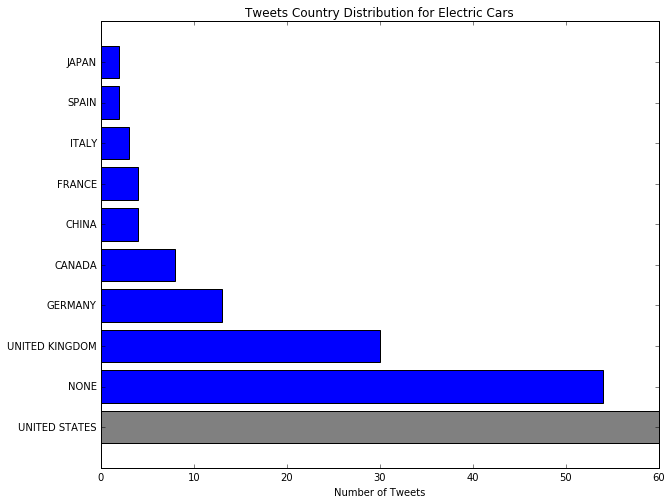

In [48]:
PlotCountryDistribution(p_electric_cars_countries, 10, 'Tweets Country Distribution for Electric Cars')

### Extracting sentiment and gender information from tweets about electric cars

Run the next cell to collect sentiment information by calling the function "getGeneralSentiment". The function returns a pandas DataFrame that contains the data frame regrouped by sentiment values and aggregated by the count function to get the number of tweets for each type of sentiment. 

In [49]:
p_electric_cars_general_sentiment = getGeneralSentiment(df_electric_cars)

Run the next cell to collect information about the gender distribution in tweets in the data set by calling the function "getMaleFemaleDistribution". This function groups the data by the USER_GENDER value and then counts the number of tweets in each group.

In [50]:
p_electric_cars_gender_distribution = getMaleFemaleDistribution(df_electric_cars)

Run the next cell to collect insights about electric cars in tweets related to the 6 car makers and to extract the gender and sentiment information from these tweets.

In [51]:
print 'Calculating the electric car sentiment for each car maker:'
electric_cars_carMakers_results = getCarMaker_Gender_Sentiment_Analysis(df_electric_cars)

Calculating the electric car sentiment for each car maker:
Done calculation for BMW
Done calculation for DAIMLER
Done calculation for GM
Done calculation for TESLA
Done calculation for TOYOTA
Done calculation for VW


Now that the information that you need is in a pandas DataFrame, run the next cell to plot the number of tweets about electric cars across the 6 car manufacturers in the data set.

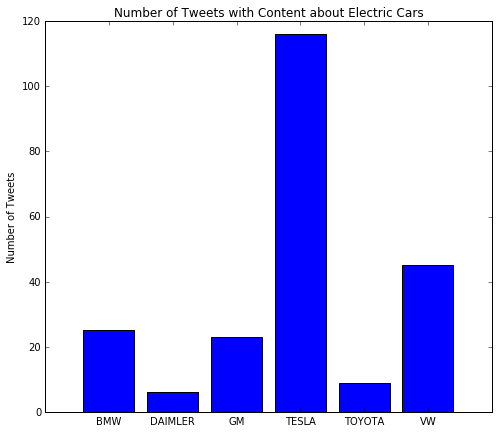

In [52]:
total_num_tweets = []
for data_car_maker in electric_cars_carMakers_results:
    total_num_tweets.append(data_car_maker[0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))
BarPlot(axes, total_num_tweets, 'Number of Tweets with Content about Electric Cars', 'Number of Tweets', car_makers_name_list)
plt.show()

### Sentiment analysis
Run the next cell to firstly plot the general distribution of sentiment values in the electric cars data frame and then to plot the distribution of these values across car makers.

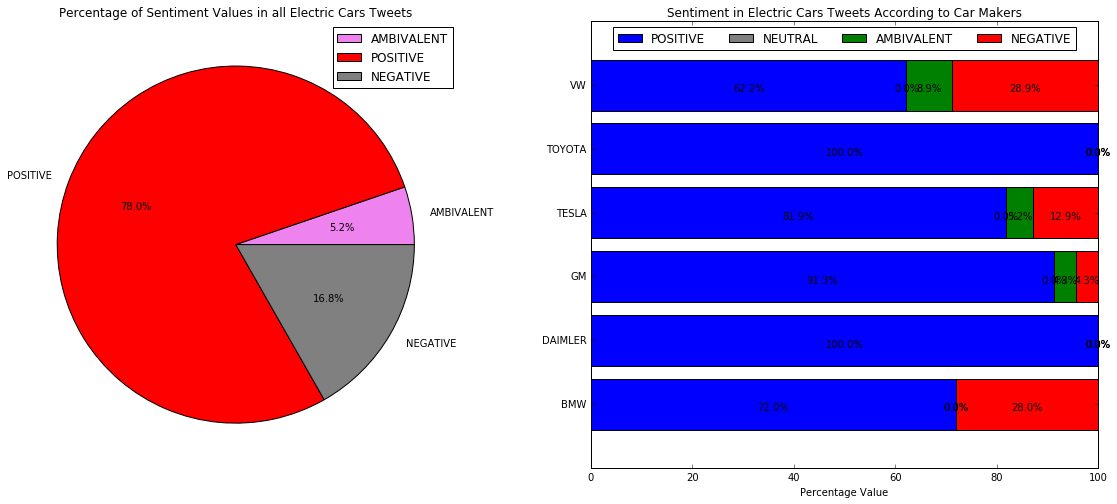

In [53]:
def getSentimentValueFromDataList(data_list, filter):
    x = data_list[3]['NUM_TWEETS'][filter].tolist()
    if (len(x) > 0):
        return x[0]
    else:
        return 0

Positive_percentage_list = []
Negative_percentage_list = []
Ambivalent_percentage_list = []
Neutral_percentage_list = []

for data_car_maker in electric_cars_carMakers_results:
    positive_filter = data_car_maker[3]['SENTIMENT'] == 'POSITIVE'
    negative_filter = data_car_maker[3]['SENTIMENT'] == 'NEGATIVE'
    neutral_filter = data_car_maker[3]['SENTIMENT'] == 'NEUTRAL'
    ambivalent_filter = data_car_maker[3]['SENTIMENT'] == 'AMBIVALENT'
    
    positive_num_tweets = getSentimentValueFromDataList(data_car_maker, positive_filter)
    negative_num_tweets = getSentimentValueFromDataList(data_car_maker, negative_filter)
    neutral_num_tweets = getSentimentValueFromDataList(data_car_maker, neutral_filter)
    ambivalent_num_tweets = getSentimentValueFromDataList(data_car_maker, ambivalent_filter)
    
    total_num_tweets_with_sentiment = positive_num_tweets + negative_num_tweets + neutral_num_tweets + ambivalent_num_tweets
    
    Positive_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, positive_num_tweets))
    Negative_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, negative_num_tweets))
    Ambivalent_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, ambivalent_num_tweets))
    Neutral_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, neutral_num_tweets))
    
print_list = [Positive_percentage_list, Neutral_percentage_list, Ambivalent_percentage_list, Negative_percentage_list]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

Plot_PieChart(p_electric_cars_general_sentiment, 'SENTIMENT', 'NUM_TWEETS',  axes[0], 'Percentage of Sentiment Values in all Electric Cars Tweets',\
                     ['Violet', 'red', 'gray', 'yellow', 'green'])
plotHorBarPercentage(axes[1], print_list, 'Sentiment in Electric Cars Tweets According to Car Makers', 'Percentage Value', car_makers_name_list, ['b', 'gray', 'green', 'red'], ['POSITIVE', 'NEUTRAL', 'AMBIVALENT', 'NEGATIVE'])

fig.subplots_adjust(hspace=1)
plt.show()

### Gender distribution

The next cell plots the distribution of gender in the electric cars data frame and then plots the distribution of these values across car makers.

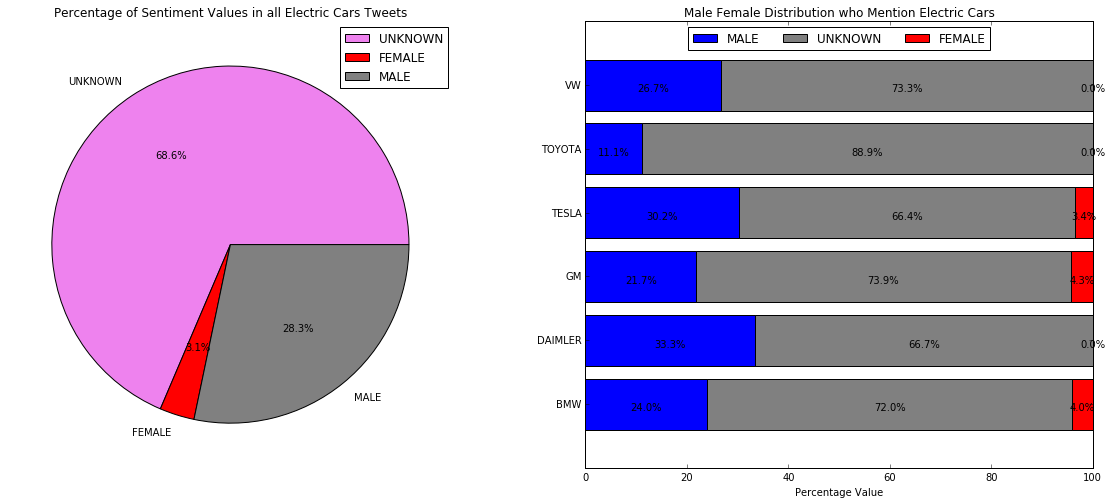

In [54]:
male_percentage_list = []
female_percentage_list = []
rest_percentage_list = []
for data_car_maker in electric_cars_carMakers_results:
    male_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[1]))
    female_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[2]))
    rest_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[0] - (data_car_maker[1] + data_car_maker[2])))
    
print_list = [male_percentage_list, rest_percentage_list, female_percentage_list]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
Plot_PieChart(p_electric_cars_gender_distribution, 'USER_GENDER', 'NUM_TWEETS', axes[0], 'Percentage of Sentiment Values in all Electric Cars Tweets',\
                     ['Violet', 'red', 'gray', 'yellow', 'green'])
plotHorBarPercentage(axes[1], print_list, 'Male Female Distribution who Mention Electric Cars', 'Percentage Value', car_makers_name_list, ['b', 'gray', 'red'], ['MALE', 'UNKNOWN', 'FEMALE'])
plt.show()

### Self-driving cars

In this section, you will perform an analysis to extract insights about self-driving cars from tweets in the data set. To find these tweets, you need to search for certain words inside the tweet text such as self-driving cars, autodrive cars, robot cars, etc. The sample uses the search terms in the list called "auto_driver_terms" to find matches. The list contains terms in four languages, namely in English, French, German, and Spanish.


In this section, you will use the constructed data frame called "df_tweets_car_maker". This data frame has a column named AUTO_DRIVE which indicates whether self-driving cars were mentioned in a tweet or not. Run the next cell to filter the data according to the value of this column.

In [55]:
df_autodrive = df_tweets_car_maker.filter(df_tweets_car_maker.AUTO_DRIVE == True)
df_autodrive.cache()

DataFrame[MESSAGE_ID: string, MESSAGE_BODY: string, SENTIMENT: string, USER_GENDER: string, USER_COUNTRY: string, POSTING_TIME: timestamp, INFLUENCE: double, BMW: boolean, DAIMLER: boolean, GM: boolean, TESLA: boolean, TOYOTA: boolean, VW: boolean, ELECTRIC_CARS: boolean, AUTO_DRIVE: boolean]

Run the next cell to calculate the number of tweets that mention self-driving cars in the data set.

In [56]:
df_autodrive.count()

167

### Country distribution

In this section, you will find the top ten countries with the highest number of tweets about self-driving cars. 
<br>
Run the next cell to build a pandas DataFrame that contains the data about the country distribution for tweets about self-driving cars. The computation calls  the helper function "getCountryDistribution".

In [57]:
p_autodrive_countries = getCountryDistribution(df_autodrive)

Run the next cell to plot the country distribution by calling the helper function "PlotCountryDistribution".

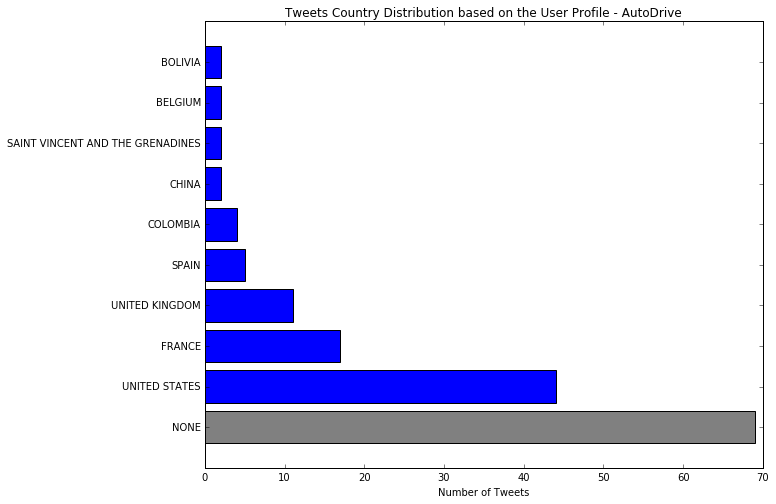

In [58]:
PlotCountryDistribution(p_autodrive_countries, 10, 'Tweets Country Distribution based on the User Profile - AutoDrive')

### Extracting sentiment and gender information from tweets about self-driving cars

Run the next cell to collect sentiment information by calling the function "getGeneralSentiment". The function returns a pandas DataFrame that contains the data frame regrouped by sentiment values and aggregated by the count function to get the number of tweets for each type of sentiment.

In [59]:
p_autodrive_general_sentiment = getGeneralSentiment(df_autodrive)

Run the next cell to collect information about the gender distribution in tweets about self-driving cars by calling the function "getMaleFemaleDistribution". This function groups the data by the USER_GENDER value and then counts the number of tweets in each group.

In [60]:
p_autodrive_gender_distribution = getMaleFemaleDistribution(df_autodrive)

Run the next cell to collect insights about self-driving cars in tweets related to the 6 car makers and to extract the gender and sentiment information from these tweets.

In [61]:
print 'Calculating the autodrive car sentiment for each car maker:'
auto_drive_carMakers_results = getCarMaker_Gender_Sentiment_Analysis(df_autodrive)

Calculating the autodrive car sentiment for each car maker:
Done calculation for BMW
Done calculation for DAIMLER
Done calculation for GM
Done calculation for TESLA
Done calculation for TOYOTA
Done calculation for VW


Now that the information that you need is in a pandas DataFrame, run the next cell to plot the number of tweets about self-driving cars across the 6 car manufacturers in the data set.

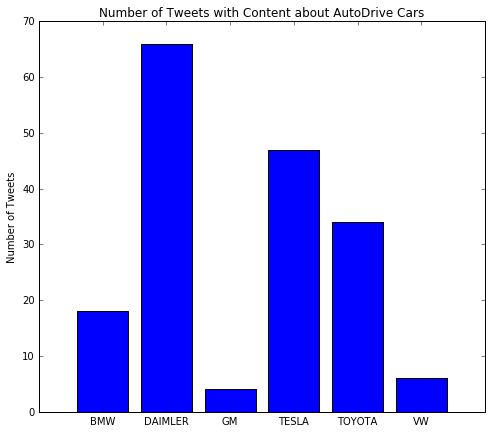

In [62]:
total_num_tweets = []
for data_car_maker in auto_drive_carMakers_results:
    total_num_tweets.append(data_car_maker[0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))
BarPlot(axes, total_num_tweets, 'Number of Tweets with Content about AutoDrive Cars', 'Number of Tweets', car_makers_name_list)
plt.show()

### Sentiment analysis
Run the next cell to firstly plot the general distribution of sentiment values in the autodrive cars data frame and then to plot the distribution of these values across car makers.

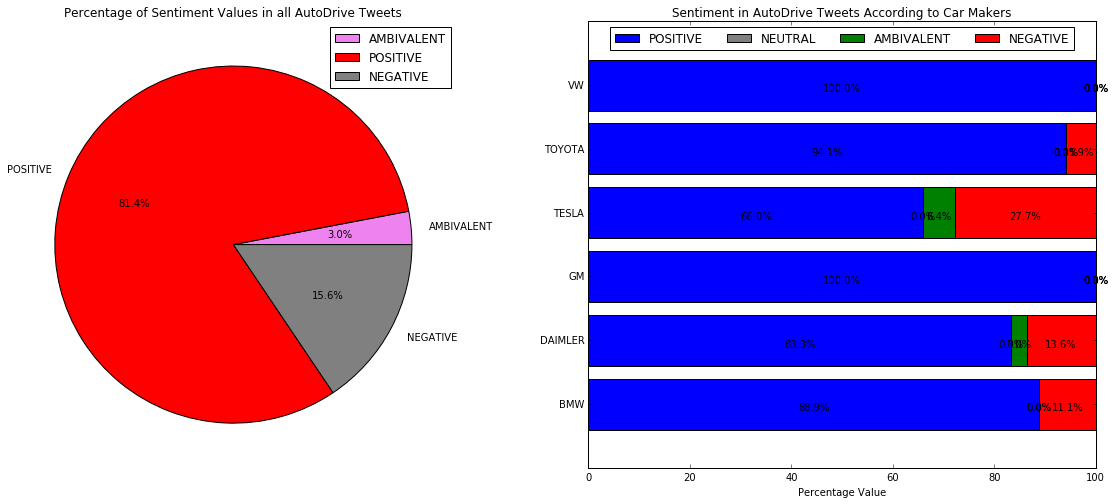

In [63]:
def getSentimentValueFromDataList(data_list, filter):
    x = data_list[3]['NUM_TWEETS'][filter].tolist()
    if (len(x) > 0):
        return x[0]
    else:
        return 0

Positive_percentage_list = []
Negative_percentage_list = []
Ambivalent_percentage_list = []
Neutral_percentage_list = []

for data_car_maker in auto_drive_carMakers_results:
    positive_filter = data_car_maker[3]['SENTIMENT'] == 'POSITIVE'
    negative_filter = data_car_maker[3]['SENTIMENT'] == 'NEGATIVE'
    neutral_filter = data_car_maker[3]['SENTIMENT'] == 'NEUTRAL'
    ambivalent_filter = data_car_maker[3]['SENTIMENT'] == 'AMBIVALENT'
    
    positive_num_tweets = getSentimentValueFromDataList(data_car_maker, positive_filter)
    negative_num_tweets = getSentimentValueFromDataList(data_car_maker, negative_filter)
    neutral_num_tweets = getSentimentValueFromDataList(data_car_maker, neutral_filter)
    ambivalent_num_tweets = getSentimentValueFromDataList(data_car_maker, ambivalent_filter)
    
    total_num_tweets_with_sentiment = positive_num_tweets + negative_num_tweets + neutral_num_tweets + ambivalent_num_tweets
    
    Positive_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, positive_num_tweets))
    Negative_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, negative_num_tweets))
    Ambivalent_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, ambivalent_num_tweets))
    Neutral_percentage_list.append(getPercentag(total_num_tweets_with_sentiment, neutral_num_tweets))
    
    

print_list = [Positive_percentage_list, Neutral_percentage_list, Ambivalent_percentage_list, Negative_percentage_list]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

Plot_PieChart(p_autodrive_general_sentiment, 'SENTIMENT', 'NUM_TWEETS',  axes[0], 'Percentage of Sentiment Values in all AutoDrive Tweets',\
                     ['Violet', 'red', 'gray', 'yellow', 'green'])

plotHorBarPercentage(axes[1], print_list, 'Sentiment in AutoDrive Tweets According to Car Makers', 'Percentage Value', car_makers_name_list, ['b', 'gray', 'green', 'red'], ['POSITIVE', 'NEUTRAL', 'AMBIVALENT', 'NEGATIVE'])

fig.subplots_adjust(hspace=1)
plt.show()

### Gender distribution

The next cell plots the distribution of gender in the autodrive cars data frame and then plots the distribution of these values across car makers.

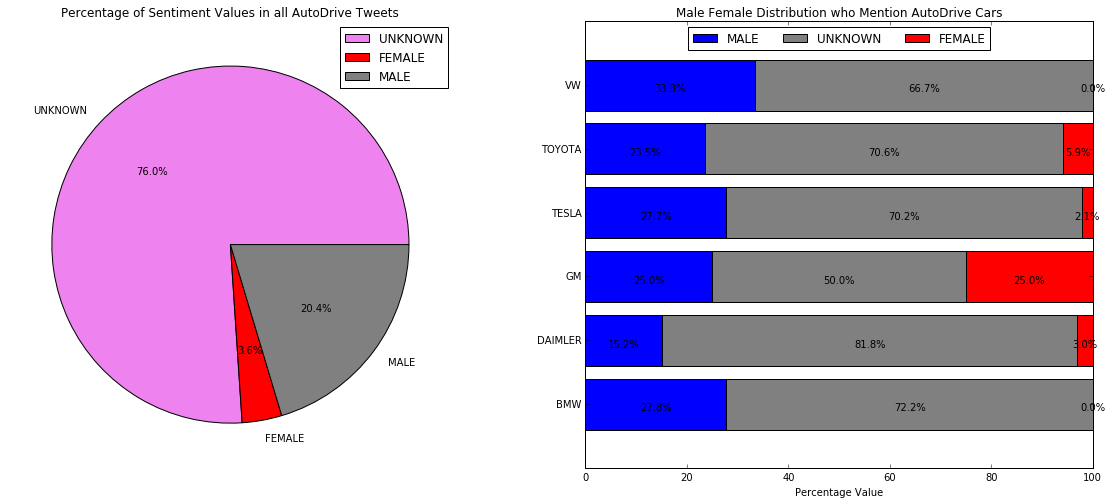

In [64]:
male_percentage_list = []
female_percentage_list = []
rest_percentage_list = []
for data_car_maker in auto_drive_carMakers_results:
    male_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[1]))
    female_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[2]))
    rest_percentage_list.append(getPercentag(data_car_maker[0], data_car_maker[0] - (data_car_maker[1] + data_car_maker[2])))
    
print_list = [male_percentage_list, rest_percentage_list, female_percentage_list]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
Plot_PieChart(p_autodrive_gender_distribution, 'USER_GENDER', 'NUM_TWEETS', axes[0], 'Percentage of Sentiment Values in all AutoDrive Tweets',\
                     ['Violet', 'red', 'gray', 'yellow', 'green'])
plotHorBarPercentage(axes[1], print_list, 'Male Female Distribution who Mention AutoDrive Cars', 'Percentage Value', car_makers_name_list, ['b', 'gray', 'red'], ['MALE', 'UNKNOWN', 'FEMALE'])
plt.show()

# 10. Summary
In this Notebook you learned how to use notebooks to analyze Twitter data and extract interesting insights from tweets. You learned how to easily perform complex computations on a large amount of data in a notebooks by using SparkContext, which enables you to start tasks on the Spark cluster. In addition, you learned how to integrate data from dashDB using the Spark connector and how to use Spark and pandas DataFrames.